In [1]:
import pandas as pd

from ray import tune
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast

In [2]:
def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

In [3]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

df_nixtla = df[['cstmr_1_id', 'yyyymm', 'sales_unit']]
df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)

In [4]:
df_nixtla.ds.min(), df_nixtla.ds.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2022-11-01 00:00:00'))

The AutoNHITS class will automatically perform hyperparamter tunning using Tune library, exploring a user-defined or default search space. Models are selected based on the error on a validation set and the best model is then stored and used during inference.

In [5]:
horizon = 12 

# Use your own config or AutoNHITS.default_config
nhits_config = {
    "learning_rate": tune.loguniform(1e-4, 1e-2), # loguniform samples over log-space, which is common for learning rates.
    "max_steps": tune.randint(500, 2000), # Random integer between 500 and 2000.
    "input_size": 1 * horizon, # if horizon is a variable and you want to just multiply it.
    "batch_size": tune.randint(1, 20),
    "windows_batch_size": tune.randint(100, 500),
    "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),
    "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]),
    "activation": "ReLU",
    "n_blocks": [1, 1, 1],
    "mlp_units": [[512, 512], [512, 512], [512, 512]],
    "interpolation_mode": "linear",
    "val_check_steps": 100,
    "random_seed": tune.randint(1, 10),
}


In [7]:
models = [AutoNHITS(h=horizon,
                    config=nhits_config, 
                    num_samples=10) # number of configurations explored --> ideally above 20!!
         ]

In [8]:
nf = NeuralForecast(
    models=models,
    freq='MS')

val_size  = 12 # 3 x 6 months
test_size = 12 # 1 x 6 months

Y_hat_df = nf.cross_validation(df=df_nixtla, 
                               val_size=val_size,
                               test_size=test_size, 
                               n_windows=None)

(_train_tune pid=20568) Seed set to 2


Epoch 1:  96%|█████████▌| 49/51 [00:01<00:00, 45.10it/s, v_num=0, train_loss_step=16.40, train_loss_epoch=18.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██▌       | 13/51 [00:00<00:00, 230.70it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  27%|██▋       | 14/51 [00:00<00:00, 230.81it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  75%|███████▍  | 38/51 [00:00<00:00, 230.99it/s]
(_train_tune pid=20568) 
Epoch 3:  92%|█████████▏| 47/51 [00:01<00:00, 46.03it/s, v_num=0, train_loss_step=15.90, train_loss_epoch=15.60, valid_loss=16.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  14%|█▎        | 7/51 [00:00<00:00, 236.79it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  63%|██████▎   | 32/51 [00:00<00:00, 240.04it/s]
(_train_tune pid=20568) 
Epoch 5:  88%|████████▊ | 45/51 [00:00<00:00, 45.68it/s, v_num=0, train_loss_step=27.50, train_loss_epoch=14.80, valid_loss=17.50]
Validation: |          | 0/? [00:00<?, 

(_train_tune pid=20568) Seed set to 8


Epoch 1:  32%|███▏      | 24/76 [00:00<00:01, 48.32it/s, v_num=0, train_loss_step=15.50, train_loss_epoch=20.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  22%|██▏       | 17/76 [00:00<00:00, 269.33it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  24%|██▎       | 18/76 [00:00<00:00, 269.18it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  61%|██████    | 46/76 [00:00<00:00, 270.11it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  62%|██████▏   | 47/76 [00:00<00:00, 270.13it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  96%|█████████▌| 73/76 [00:00<00:00, 262.85it/s]
(_train_tune pid=20568) 
Epoch 2:  63%|██████▎   | 48/76 [00:00<00:00, 50.13it/s, v_num=0, train_loss_step=12.90, train_loss_epoch=15.70, valid_loss=15.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  18%|█▊        | 14/76 [00:00<00:00, 267.50it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  20%|█▉        | 15/76 [00:00<00:00, 267.75it

(_train_tune pid=20568) Seed set to 5


Epoch 2:   8%|▊         | 4/48 [00:00<00:00, 61.06it/s, v_num=0, train_loss_step=16.90, train_loss_epoch=15.80]
(_train_tune pid=20568) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/48 [00:00<?, ?it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  52%|█████▏    | 25/48 [00:00<00:00, 245.99it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  54%|█████▍    | 26/48 [00:00<00:00, 245.90it/s]
(_train_tune pid=20568) 
Epoch 4:  17%|█▋        | 8/48 [00:00<00:00, 58.56it/s, v_num=0, train_loss_step=28.40, train_loss_epoch=14.90, valid_loss=15.50]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  12%|█▎        | 6/48 [00:00<00:00, 240.70it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  67%|██████▋   | 32/48 [00:00<00:00, 246.78it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  69%|██████▉   | 33/48 [00:00<00:00, 246.83it/s]
(_train_tune pid=20568) 
Epoch 6:  25%|██▌       | 12/48 [00:00<00:00, 61.14it/s, v

(_train_tune pid=20568) Seed set to 6


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 218.32it/s]
                                                                            
Epoch 1:  56%|█████▋    | 36/64 [00:00<00:00, 58.86it/s, v_num=0, train_loss_step=22.20, train_loss_epoch=19.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  14%|█▍        | 9/64 [00:00<00:00, 240.38it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  16%|█▌        | 10/64 [00:00<00:00, 240.59it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  59%|█████▉    | 38/64 [00:00<00:00, 260.56it/s]
(_train_tune pid=20568) 
Epoch 3:  12%|█▎        | 8/64 [00:00<00:00, 57.91it/s, v_num=0, train_loss_step=15.10, train_loss_epoch=16.00, valid_loss=16.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  14%|█▍        | 9/64 [00:00<00:00, 261.59it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  56%|█████▋    | 36/64 [00:00<00:00, 265.67it/s]
(_train_tune pid=20568) 
Validation DataLoa

(_train_tune pid=20568) Seed set to 5


Epoch 1:  82%|████████▏ | 45/55 [00:00<00:00, 48.66it/s, v_num=0, train_loss_step=14.00, train_loss_epoch=22.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  42%|████▏     | 23/55 [00:00<00:00, 262.52it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  91%|█████████ | 50/55 [00:00<00:00, 263.15it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  93%|█████████▎| 51/55 [00:00<00:00, 263.10it/s]
(_train_tune pid=20568) 
Epoch 3:  64%|██████▎   | 35/55 [00:00<00:00, 55.29it/s, v_num=0, train_loss_step=22.30, train_loss_epoch=15.90, valid_loss=15.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  29%|██▉       | 16/55 [00:00<00:00, 258.94it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  31%|███       | 17/55 [00:00<00:00, 259.16it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  78%|███████▊  | 43/55 [00:00<00:00, 251.13it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  80%|████████  | 44/55 [00:00<00:00, 251.11it

(_train_tune pid=20568) Seed set to 4


Epoch 1:  82%|████████▏ | 45/55 [00:00<00:00, 46.11it/s, v_num=0, train_loss_step=14.90, train_loss_epoch=15.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   5%|▌         | 3/55 [00:00<00:00, 250.40it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  49%|████▉     | 27/55 [00:00<00:00, 238.27it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  91%|█████████ | 50/55 [00:00<00:00, 228.63it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  93%|█████████▎| 51/55 [00:00<00:00, 228.93it/s]
(_train_tune pid=20568) 
Epoch 3:  64%|██████▎   | 35/55 [00:00<00:00, 48.64it/s, v_num=0, train_loss_step=10.90, train_loss_epoch=15.40, valid_loss=16.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  35%|███▍      | 19/55 [00:00<00:00, 259.71it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  36%|███▋      | 20/55 [00:00<00:00, 256.38it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  85%|████████▌ | 47/55 [00:00<00:00, 256.52it/

(_train_tune pid=20568) Seed set to 1


Epoch 1:   5%|▌         | 5/95 [00:00<00:01, 56.56it/s, v_num=0, train_loss_step=20.00, train_loss_epoch=16.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  24%|██▍       | 23/95 [00:00<00:00, 279.46it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  25%|██▌       | 24/95 [00:00<00:00, 279.36it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  56%|█████▌    | 53/95 [00:00<00:00, 279.39it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  57%|█████▋    | 54/95 [00:00<00:00, 279.36it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  58%|█████▊    | 55/95 [00:00<00:00, 279.30it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  88%|████████▊ | 84/95 [00:00<00:00, 279.92it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  89%|████████▉ | 85/95 [00:00<00:00, 279.85it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  91%|█████████ | 86/95 [00:00<00:00, 279.85it/s]
(_train_tune pid=20568) 
Epoch 2:  11%|█         | 10/95 [00:00<00:01, 56.2

(_train_tune pid=20568) Seed set to 4


Epoch 1:   5%|▌         | 5/95 [00:00<00:01, 46.38it/s, v_num=0, train_loss_step=21.40, train_loss_epoch=18.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  20%|██        | 19/95 [00:00<00:00, 265.95it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  48%|████▊     | 46/95 [00:00<00:00, 265.51it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  49%|████▉     | 47/95 [00:00<00:00, 265.71it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  51%|█████     | 48/95 [00:00<00:00, 265.99it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  81%|████████  | 77/95 [00:00<00:00, 270.65it/s]
(_train_tune pid=20568) 
Epoch 2:  11%|█         | 10/95 [00:00<00:01, 56.59it/s, v_num=0, train_loss_step=14.50, train_loss_epoch=16.80, valid_loss=15.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   6%|▋         | 6/95 [00:00<00:00, 257.76it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:   7%|▋         | 7/95 [00:00<00:00, 259.48it/s]

(_train_tune pid=20568) Seed set to 1


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 203.67it/s]
                                                                            
Epoch 0:  79%|███████▊  | 100/127 [00:01<00:00, 52.88it/s, v_num=0, train_loss_step=23.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|▏         | 2/127 [00:00<00:00, 260.98it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:   2%|▏         | 3/127 [00:00<00:00, 243.58it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  24%|██▍       | 31/127 [00:00<00:00, 269.28it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  25%|██▌       | 32/127 [00:00<00:00, 269.39it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  26%|██▌       | 33/127 [00:00<00:00, 269.60it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  48%|████▊     | 61/127 [00:00<00:00, 271.39it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  49%|████▉     | 62/127 [00:00<00:00, 271.44it/s]
(_train_tune pid=20568) 
Validation 

(_train_tune pid=20568) Seed set to 5


Epoch 1:  69%|██████▉   | 41/59 [00:00<00:00, 43.63it/s, v_num=0, train_loss_step=12.70, train_loss_epoch=699.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  39%|███▉      | 23/59 [00:00<00:00, 237.53it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  81%|████████▏ | 48/59 [00:00<00:00, 239.55it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  83%|████████▎ | 49/59 [00:00<00:00, 239.92it/s]
(_train_tune pid=20568) 
Epoch 3:  39%|███▉      | 23/59 [00:00<00:00, 43.97it/s, v_num=0, train_loss_step=35.00, train_loss_epoch=18.20, valid_loss=16.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  42%|████▏     | 25/59 [00:00<00:00, 265.42it/s]
(_train_tune pid=20568) 
Validation DataLoader 0:  90%|████████▉ | 53/59 [00:00<00:00, 266.30it/s]
(_train_tune pid=20568) 
Epoch 5:   8%|▊         | 5/59 [00:00<00:01, 44.67it/s, v_num=0, train_loss_step=10.00, train_loss_epoch=18.40, valid_loss=17.00]
Validation: |          | 0/? [00:00<?, 

Seed set to 5


Epoch 24:  51%|█████     | 30/59 [00:00<00:00, 36.72it/s, v_num=0, train_loss_step=15.70, train_loss_epoch=14.70, valid_loss=14.70]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [14]:
nf.models[0].results.get_best_result().config

{'learning_rate': 0.009047328199236218,
 'max_steps': 1446,
 'input_size': 12,
 'batch_size': 13,
 'windows_batch_size': 395,
 'n_pool_kernel_size': [16, 8, 1],
 'n_freq_downsample': [24, 12, 1],
 'activation': 'ReLU',
 'n_blocks': [1, 1, 1],
 'mlp_units': [[512, 512], [512, 512], [512, 512]],
 'interpolation_mode': 'linear',
 'val_check_steps': 100,
 'random_seed': 5,
 'h': 12,
 'loss': MAE(),
 'valid_loss': MAE()}

In [15]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoNHITS'].values

n_series = len(df_nixtla.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (757, 1, 12)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (757, 1, 12)


In [16]:
y_true[2,0], y_hat[2,0]

(array([108.64312, 102.37527, 100.49487, 108.39726,  86.63121, 103.17898,
        116.39654,  98.15518, 101.40378, 124.75819, 100.79751, 128.72893]),
 array([103.74373 , 102.74734 , 107.215454, 114.08312 , 115.25925 ,
        122.35994 , 123.327576, 122.69431 , 123.99138 , 124.336136,
        130.95538 , 116.35348 ], dtype=float32))

In [17]:
from neuralforecast.losses.numpy import mae, mse, smape, mape

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))
print('mape: ', mape(y_hat, y_true))
print('smape: ', smape(y_hat, y_true))

MAE:  14.370212574656101
MSE:  712.6185016880214
mape:  4.765491297877893
smape:  0.5523693996601228


$\text{MAPE} = \frac{100\%}{n} \sum \frac{|F_t - A_t|}{|A_t|}$

$\text{SMAPE} = \frac{100\%}{n} \sum \frac{|F_t - A_t|}{(|A_t| + |F_t|)/2}$

$F_{t}=$ forecast at point $t$

$A_{t}=$ actual at point $t$

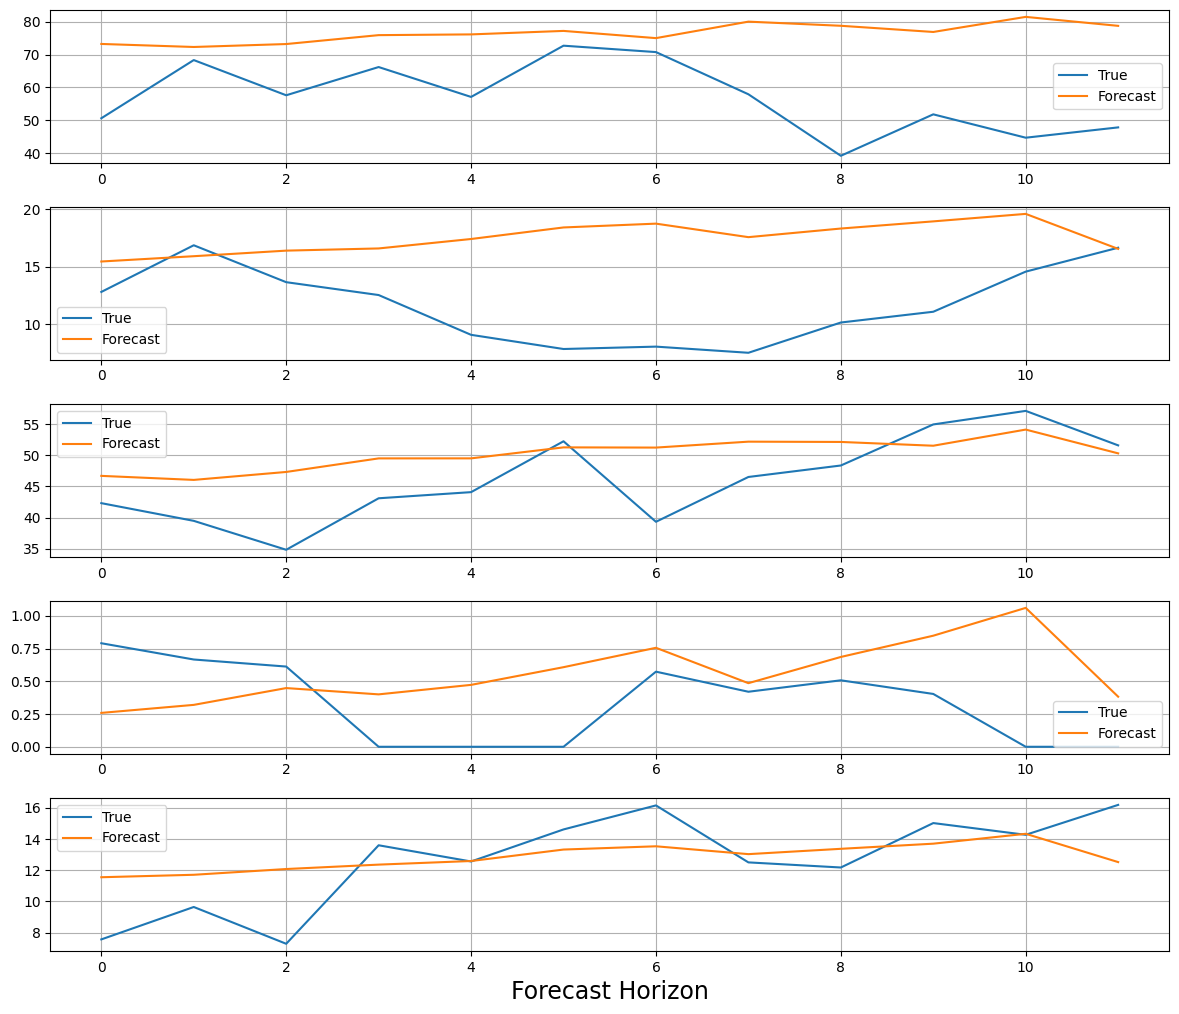

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 10))
fig.tight_layout()

for idx, w_idx in enumerate(np.random.choice(len(y_hat), 5, replace=False)):
    axs[idx].plot(y_true[w_idx, 0,:],label='True')
    axs[idx].plot(y_hat[w_idx, 0,:],label='Forecast')
    axs[idx].grid()
    if idx==4:
        axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
    axs[idx].legend()

plt.show()
plt.close()